In [1]:
import cv2
import cvlib as cv
from cvlib.object_detection import draw_bbox
from IPython.display import Image, display

In [2]:
FILE_NAME = "./images/oranges.jpg"
OUT_FILE_NAME = "./images_with_boxes/image-out.jpg"

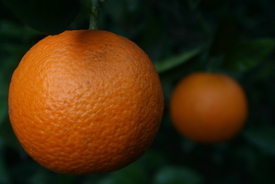

In [3]:
display(Image(FILE_NAME))

In [4]:
def detect_and_draw_box(FILE_NAME, confidence=0.2, model="yolov3-tiny"):
    img = cv2.imread(FILE_NAME)
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}n")
    output_image = draw_bbox(img, bbox, label, conf)
    cv2.imwrite(OUT_FILE_NAME, output_image)
    display(Image(OUT_FILE_NAME))

Detected object: orange with confidence level of 0.6185586452484131n
Detected object: orange with confidence level of 0.5561693906784058n


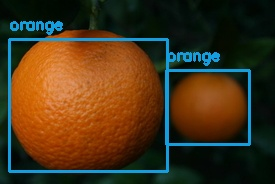

In [5]:
detect_and_draw_box(FILE_NAME)

In [6]:
import os
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [7]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [8]:
# conda install -c conda-forge python-unicorn

In [9]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying a ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://localhost:8000/docs."


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [ ]:
nest_asyncio.apply()
host = "0.0.0.0" if os.getenv("DOCKER-SETUP") else "127.0.0.1"
uvicorn.run(app, host=host, port=8000)

INFO:     Started server process [6506]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:51977 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:52046 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:52049 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:52051 - "POST /predict?model=yolov3-tiny HTTP/1.1" 200 OK
